## 查找异常数据
---

#### I. 获取训练集中高度或者宽度小于50的图片。

In [2]:
from keras.preprocessing.image import img_to_array, load_img
import os
import numpy as np
import matplotlib.pyplot as plt

targetnames = os.listdir('train/')
bad_picture = []
for name in targetnames[1:]:
    img = load_img('train/'+name)
    x = img_to_array(img)
    if x.shape[0] < 50 or x.shape[1] < 50:
        bad_picture.append(name) 
print(bad_picture)

['dog.4367.jpg', 'dog.11248.jpg', 'dog.9246.jpg', 'dog.10747.jpg', 'cat.10392.jpg', 'dog.10733.jpg', 'cat.2433.jpg', 'cat.9171.jpg', 'dog.1324.jpg', 'dog.7011.jpg', 'dog.11686.jpg', 'cat.6402.jpg', 'cat.6614.jpg', 'cat.5527.jpg', 'cat.4821.jpg', 'cat.5534.jpg', 'dog.9705.jpg', 'dog.2652.jpg']


Len img_list: 18


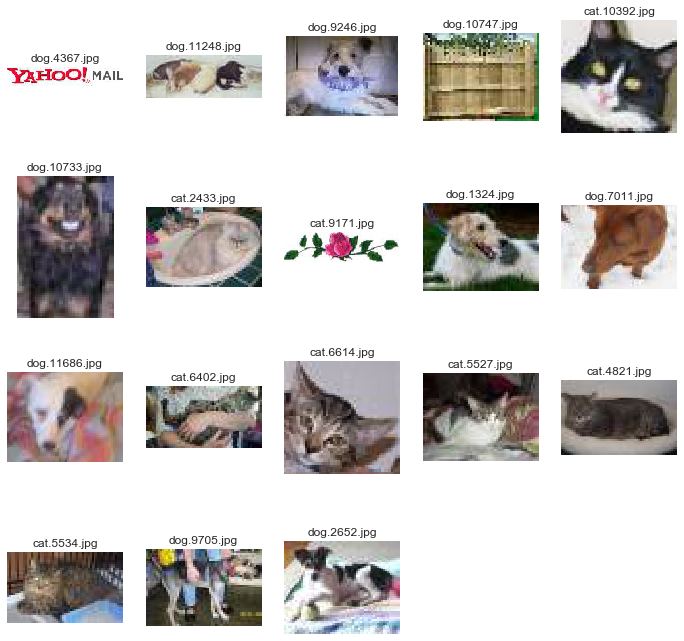

In [3]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
# from keras.preprocessing import image
from math import ceil
plt.style.use('seaborn-white')
        
def show_img_list(img_list, size = (12, 12)):
    print("Len img_list: {}".format(len(img_list)))
    plt.figure(figsize=size)
    subplot_row = ceil(len(img_list) / 5)
    for i in range(0, len(img_list)):
        plt.subplot(subplot_row, 5, i+1)
        img = load_img('train/'+ img_list[i])
        plt.title(img_list[i])
        plt.axis('off')
        plt.imshow(img)
        
show_img_list(bad_picture)

#### II. 通过对图片中的色彩-像素比进行 IQR 分析，可以发现很多分辨率低、无关的图片

In [ ]:
from PIL import Image
import os
import numpy as np
import shutil
from collections import Counter

targetnames = os.listdir('train/')
ratio_list = []

for name in targetnames[1:]:
    im = Image.open('train/' + name)
    x = im.histogram(mask=None)
    count = Counter(x)    
    ratio_list.append(float(len(count))/len(x))

In [ ]:
import numpy as np

q99, q01 = np.percentile(ratio_list, [99, 1])

print(q99, q01)

In [ ]:
from keras.preprocessing.image import img_to_array, load_img
import shutil
import os
import matplotlib.pyplot as plt
from math import ceil
%matplotlib inline

plt.style.use('seaborn-white')

outlier_picture = []
targetnames = os.listdir('train/')
for name in targetnames[:]:
    im = Image.open('train/' + name)
    x = im.histogram(mask=None)
    count = Counter(x)
    if float(len(count))/len(x) < q01:
        outlier_picture.append(name)
#         img = load_img('train/'+name)     
#         plt.title(name)
#         plt.imshow(img)
#         plt.show()
        
print(outlier_picture)

#### III. 采用预处理模型剔除异常数据

In [1]:
import csv
import matplotlib.pyplot as plt

%matplotlib inline  

plt.style.use('seaborn-white')

img_size = (299, 299)

def get_imageNet_class(file_path):
    category_class = []
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        for line in reader:
            if line[1] == '狗' or line[1] == '猫':
                category_class.append(line[0])
    return category_class

imageNet_class = get_imageNet_class('ImageNetClasses.csv')

In [2]:
import os

os.chdir("{}/image".format(os.getcwd()))

In [3]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
import numpy as np
import random
from math import ceil

def get_outlier_predictions(train_path, model, img_size, top=10):
    outlier_predictions = {}
    targetnames = os.listdir(train_path)
    for name in targetnames[:]:
        img = image.load_img(train_path + name, target_size=img_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        preds = model.predict(x)
        predictions = decode_predictions(preds, top=top)[0]
        #if predictions not in imageNet_class:
        #    outlier_predictions.append(name)
        outlier_predictions[name] = predictions
            
    return outlier_predictions    

Using TensorFlow backend.


In [4]:
model = InceptionV3(weights='imagenet')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
outlier_list = get_outlier_predictions('train/', model, img_size, 10)

In [6]:
import csv

def writer_csv(csv_path, data):
    """
    :type csv_path: str
    :type data: dict
    :rtype: None
    """
    with open(csv_path, 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in data.items():
            writer.writerow([key, value])
            
def readr_csv(csv_path):
    """
    :type cav_path: str
    :rtpye: dict
    """
    with open(csv_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        return dict(reader)

In [7]:
csv_path = 'train_decode_predictions.csv'
writer_csv(csv_path, outlier_list)

In [8]:
outlier_list = readr_csv(csv_path)

In [9]:
len(outlier_list)

25000

In [10]:
def get_result_list(pred):
    result = []
    for key, value in pred.items():
        value = eval(value)
        pred_list = [ x[0] for x in value ]
        pred_list = [ 1 for x in pred_list if x in imageNet_class ]
        if sum(pred_list) == 0:
            result.append(key)
        
    return result

In [11]:
outlier_result = get_result_list(outlier_list)

In [12]:
len(outlier_result)

191

In [13]:
import cv2

def plt_outlier_img_1(outlier_list):
    plt.figure(figsize=(16, 68), dpi=80)
    subplot_row = ceil(len(outlier_list) / 5)
    for i in range(0, len(outlier_list)):
        plt.subplot(subplot_row, 5, i+1)
        img = cv2.imread('train/'+ outlier_list[i])
        img = cv2.resize(img, img_size)
        x = img.copy()
        x.astype(np.float32)
        plt.title(outlier_list[i])
        plt.axis('off')
        plt.imshow(x[:,:,::-1])
        
#         img = image.load_img('train/'+ outlier_list[i])
#         x = image.img_to_array(img)
#         plt.title(outlier_list[i])
#         #plt.axis('off')
#         plt.tight_layout()
#         plt.imshow(img)

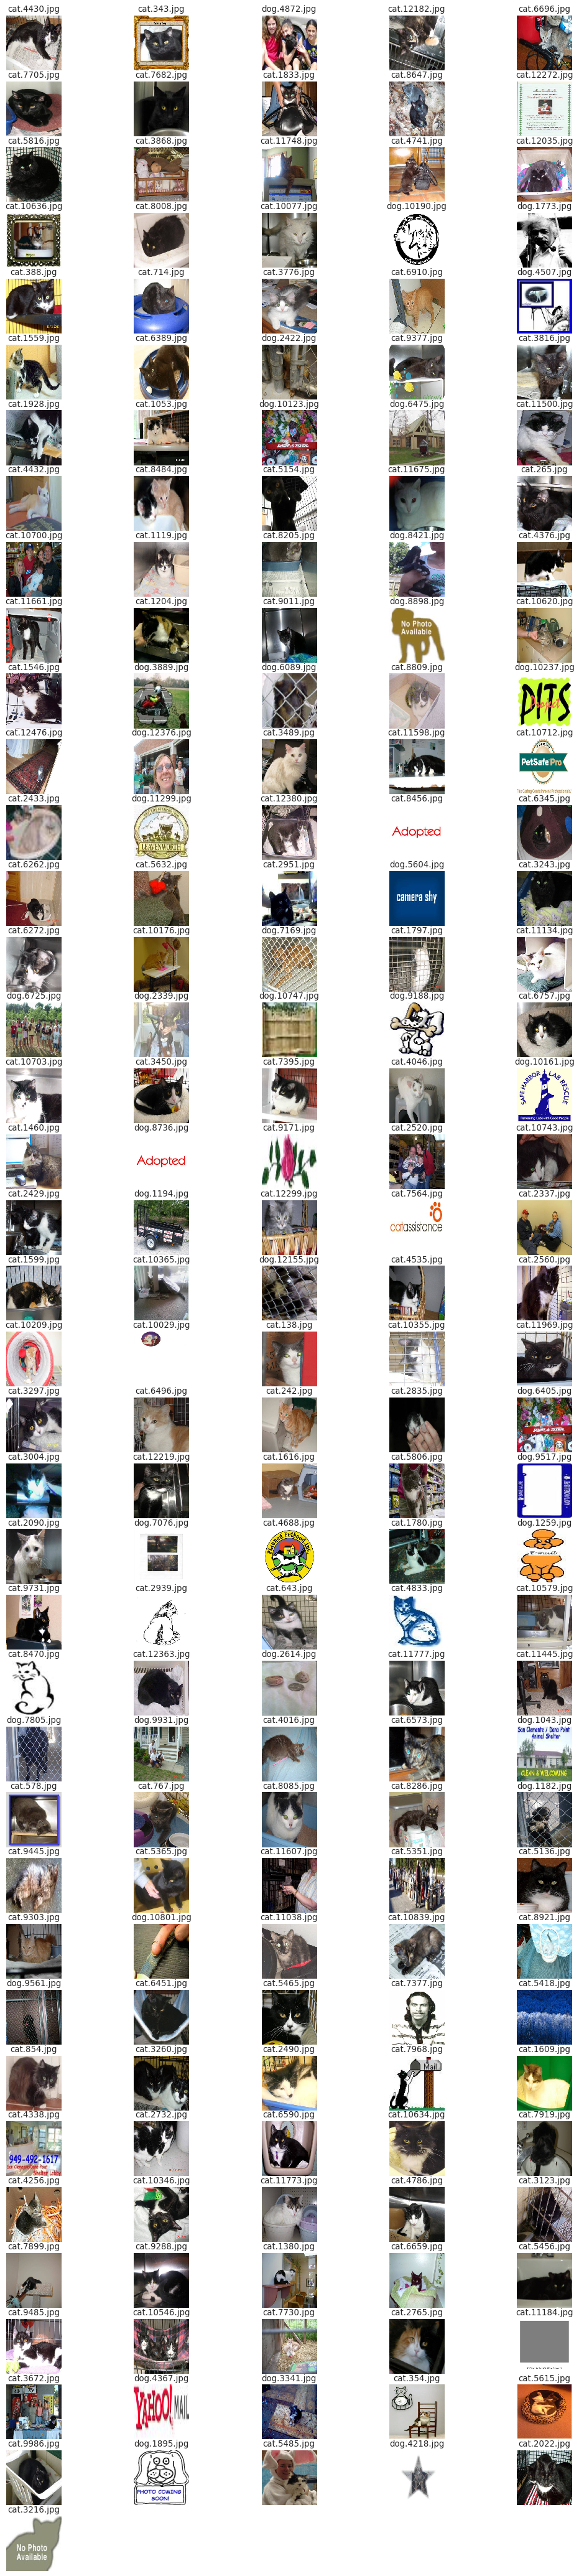

In [14]:
plt_outlier_img_1(outlier_result)

#### IV. 综合上面查找的结果，手动把异常图片挑选出来

Len outlier_list: 55
Len outlier_list: 52


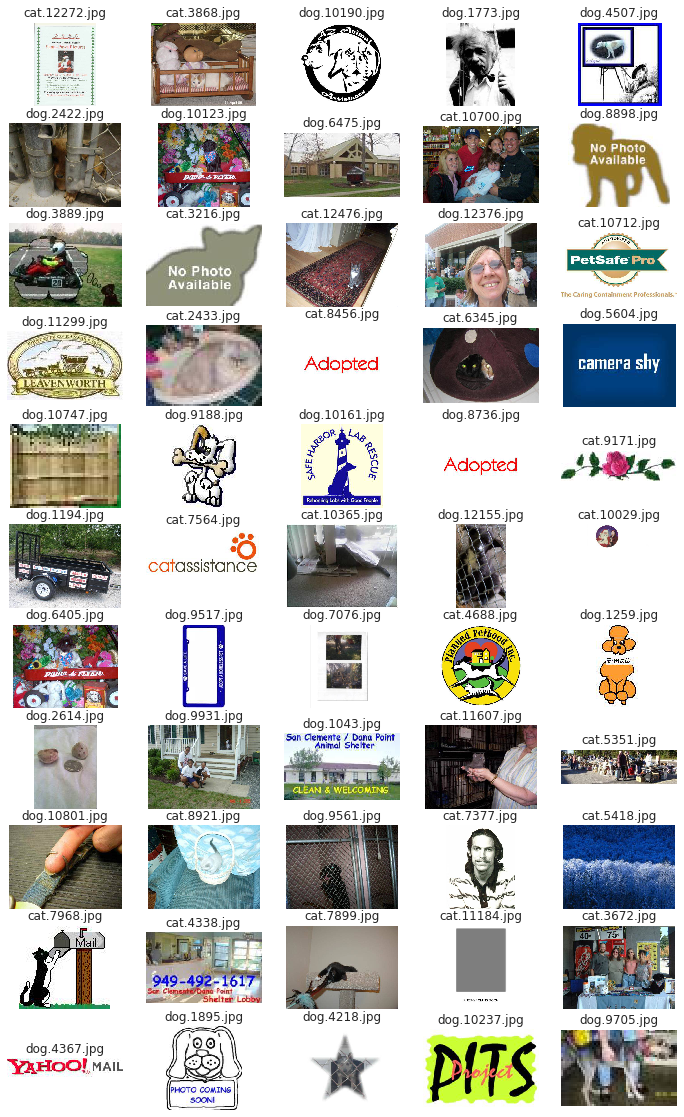

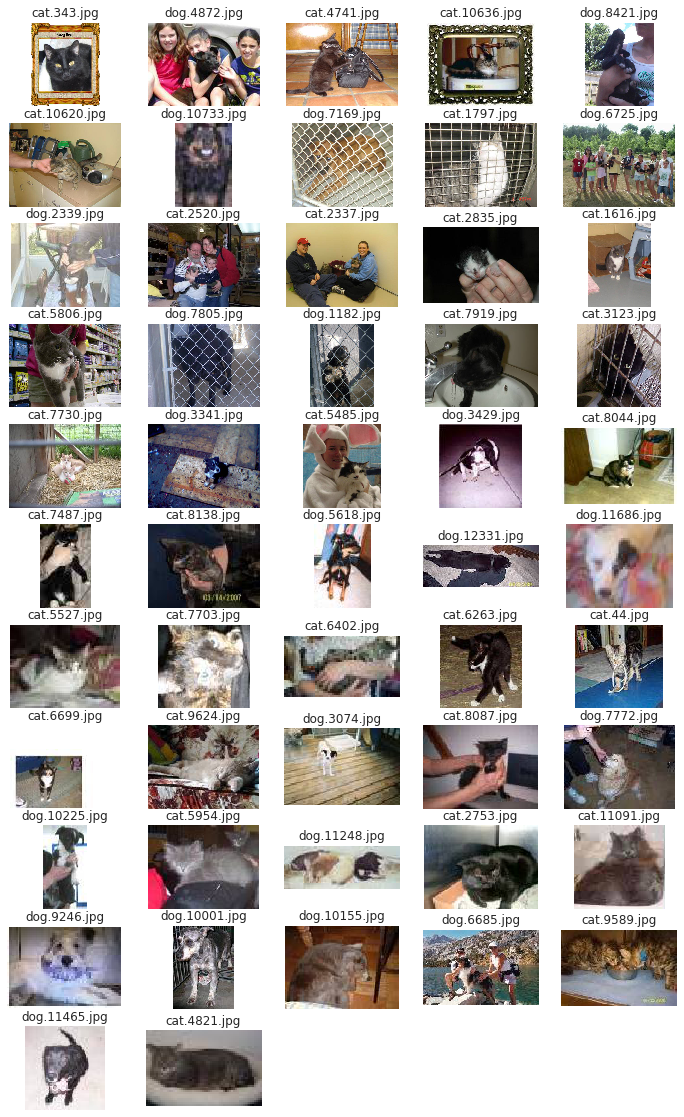

In [22]:
import shutil

pick_out_outlier_list1 = ['cat.12272.jpg', 'cat.3868.jpg', 'dog.10190.jpg', 'dog.1773.jpg', 'dog.4507.jpg', 'dog.2422.jpg', 
                         'dog.10123.jpg', 'dog.6475.jpg', 'cat.10700.jpg', 'dog.8898.jpg', 'dog.3889.jpg','cat.3216.jpg',
                         'cat.12476.jpg', 'dog.12376.jpg', 'cat.10712.jpg', 'dog.11299.jpg', 'cat.2433.jpg', 'cat.8456.jpg', 
                         'cat.6345.jpg', 'dog.5604.jpg', 'dog.10747.jpg', 'dog.9188.jpg', 'dog.10161.jpg', 'dog.8736.jpg', 
                         'cat.9171.jpg', 'dog.1194.jpg', 'cat.7564.jpg', 'cat.10365.jpg', 'dog.12155.jpg', 'cat.10029.jpg', 
                         'dog.6405.jpg', 'dog.9517.jpg', 'dog.7076.jpg', 'cat.4688.jpg', 'dog.1259.jpg', 'dog.2614.jpg', 
                         'dog.9931.jpg', 'dog.1043.jpg', 'cat.11607.jpg', 'cat.5351.jpg', 'dog.10801.jpg', 'cat.8921.jpg',
                         'dog.9561.jpg', 'cat.7377.jpg', 'cat.5418.jpg', 'cat.7968.jpg', 'cat.4338.jpg', 'cat.7899.jpg', 
                         'cat.11184.jpg', 'cat.3672.jpg', 'dog.4367.jpg', 'dog.1895.jpg', 'dog.4218.jpg','dog.10237.jpg','dog.9705.jpg']
                         
pick_out_outlier_list2 = ['cat.343.jpg', 'dog.4872.jpg', 'cat.4741.jpg', 'cat.10636.jpg', 'dog.8421.jpg', 'cat.10620.jpg', 
                         'dog.10733.jpg', 'dog.7169.jpg', 'cat.1797.jpg', 'dog.6725.jpg', 'dog.2339.jpg', 'cat.2520.jpg', 
                         'cat.2337.jpg', 'cat.2835.jpg', 'cat.1616.jpg', 'cat.5806.jpg', 'dog.7805.jpg', 'dog.1182.jpg', 
                         'cat.7919.jpg', 'cat.3123.jpg', 'cat.7730.jpg', 'dog.3341.jpg', 'cat.5485.jpg', 'dog.3429.jpg',
                         'cat.8044.jpg', 'cat.7487.jpg', 'cat.8138.jpg', 'dog.5618.jpg', 'dog.12331.jpg', 'dog.11686.jpg', 
                         'cat.5527.jpg', 'cat.7703.jpg', 'cat.6402.jpg', 'cat.6263.jpg', 'cat.44.jpg', 'cat.6699.jpg', 
                         'cat.9624.jpg', 'dog.3074.jpg', 'cat.8087.jpg', 'dog.7772.jpg', 'dog.10225.jpg', 'cat.5954.jpg', 
                         'dog.11248.jpg', 'cat.2753.jpg', 'cat.11091.jpg', 'dog.9246.jpg', 'dog.10001.jpg', 'dog.10155.jpg',
                         'dog.6685.jpg', 'cat.9589.jpg', 'dog.11465.jpg', 'cat.4821.jpg']

def show_img_list(img_list, size = (12, 12)):
    print("Len outlier_list: {}".format(len(img_list)))
    plt.figure(figsize=size)
    subplot_row = ceil(len(img_list) / 5)
    for i in range(0, len(img_list)):
        plt.subplot(subplot_row, 5, i+1)
        img = image.load_img('train/'+ img_list[i])
        plt.title(img_list[i])
        plt.axis('off')
        plt.imshow(img)
        
show_img_list(pick_out_outlier_list1, (12,20))
show_img_list(pick_out_outlier_list2, (12,20))

In [ ]:
import os
import shutil

train_filenames = os.listdir('train')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

rmrf_mkdir('img_train')
os.mkdir('img_train/cat')
os.mkdir('img_train/dog')

rmrf_mkdir('img_test')
os.symlink('../test/', 'img_test/test')

for filename in train_cat:
    os.symlink('../../train/'+filename, 'img_train/cat/'+filename)

for filename in train_dog:
    os.symlink('../../train/'+filename, 'img_train/dog/'+filename)

In [ ]:
# import seaborn as sns

# plt.style.use('ggplot')

# x = ['train_cat', 'train_dog', 'test']
# y = [len(os.listdir('img_train/cat')), len(os.listdir('img_train/dog')), len(os.listdir('test'))]
# ax = sns.barplot(x=x, y=y)

In [ ]:
# s_count = """image数据集中，猫的数量：{}，狗的数量：{}，测试集图片数量：{}""".format(len(os.listdir('img_train/cat')), len(os.listdir('img_train/dog')),len(os.listdir('test')))
# s_count